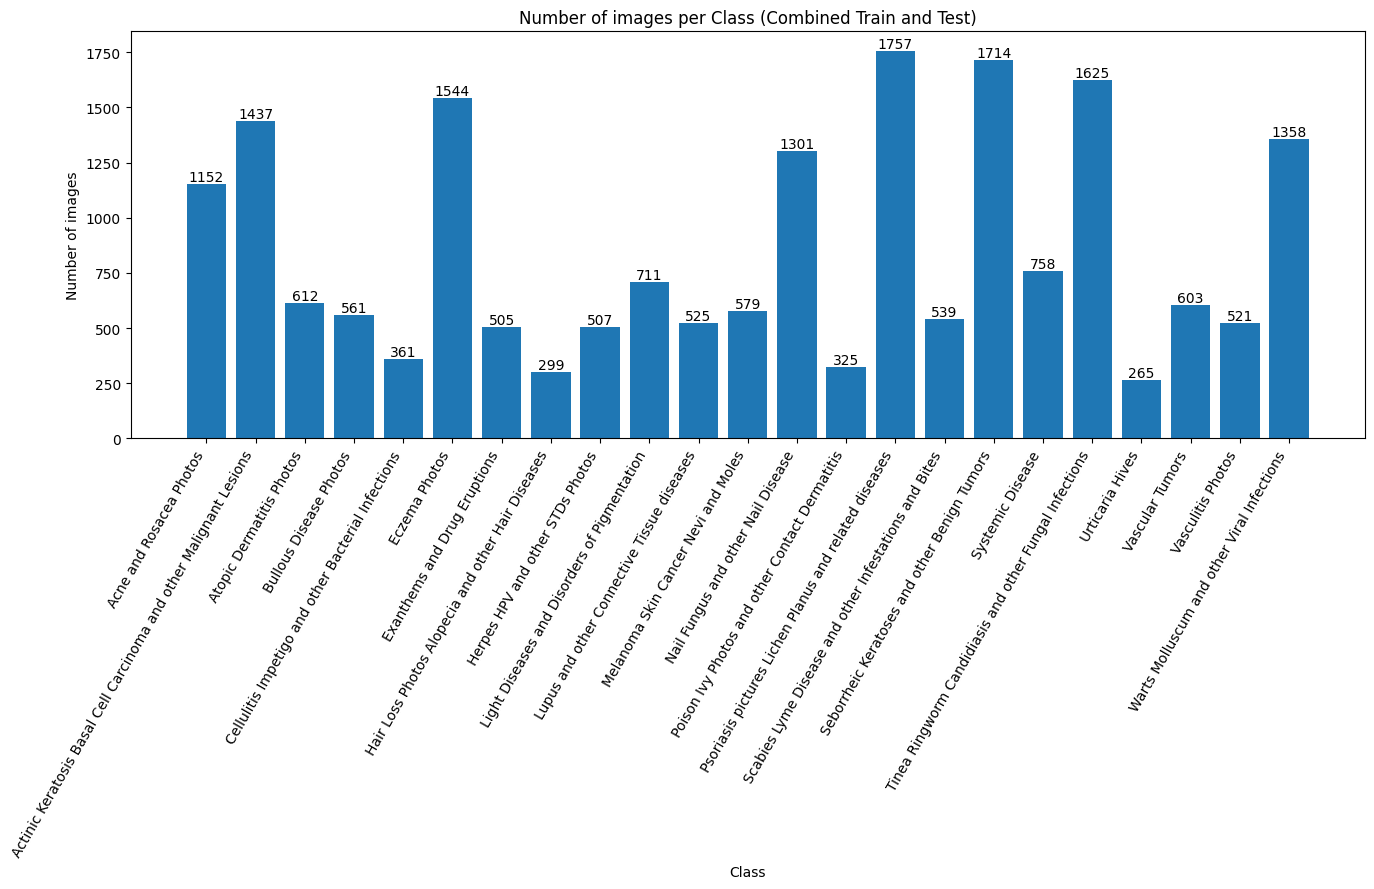

In [1]:
import os
import matplotlib.pyplot as plt

# Set the path to the dataset directory
dataset_dir = '/kaggle/input/dermnet'

# Set the path to the train and test directories
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Get the list of class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(train_dir))

# Initialize lists to store the number of images for each class
train_data_counts = []
test_data_counts = []

# Iterate over each class
for class_name in class_names:
    # Count the number of images in the train directory for the current class
    train_class_dir = os.path.join(train_dir, class_name)
    train_data_count = len(os.listdir(train_class_dir))
    train_data_counts.append(train_data_count)

    # Count the number of images in the test directory for the current class
    test_class_dir = os.path.join(test_dir, class_name)
    test_data_count = len(os.listdir(test_class_dir))
    test_data_counts.append(test_data_count)

# Combine the train and test data counts for each class
combined_data_counts = [train_count + test_count for train_count, test_count in zip(train_data_counts, test_data_counts)]

# Create a larger bar plot for each class with the combined data counts
plt.figure(figsize=(14, 9))
plt.bar(class_names, combined_data_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images per Class (Combined Train and Test)')
plt.xticks(rotation=60, ha='right')

# Add the number of images as text above each bar
for i, count in enumerate(combined_data_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

In [2]:
import os
import random
import shutil

def count_images(folder):
    """
    Count the number of images in a folder.

    Args:
        folder (str): Path to the folder.

    Returns:
        int: Number of images in the folder.
    """
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

def oversample(folder, target_count):
    """
    Oversample the images in a folder to reach a target count.

    Args:
        folder (str): Path to the folder.
        target_count (int): Target number of images in the folder.
    """
    image_files = os.listdir(folder)
    current_count = len(image_files)
    oversample_count = target_count - current_count

    while oversample_count > 0:
        random_file = random.choice(image_files)
        source = os.path.join(folder, random_file)
        new_file = os.path.splitext(random_file)[0] + f'_oversampled_{oversample_count}' + os.path.splitext(random_file)[1]
        destination = os.path.join(folder, new_file)
        shutil.copy(source, destination)
        oversample_count -= 1

def undersample(folder, target_count):
    """
    Undersample the images in a folder to reduce to a target count.

    Args:
        folder (str): Path to the folder.
        target_count (int): Target number of images in the folder.
    """
    image_files = os.listdir(folder)
    current_count = len(image_files)

    if current_count > target_count:
        files_to_remove = random.sample(image_files, current_count - target_count)
        for file in files_to_remove:
            os.remove(os.path.join(folder, file))

def move_images(source_folder, destination_folder, count):
    """
    Move a specified number of random images from a source folder to a destination folder.

    Args:
        source_folder (str): Path to the source folder.
        destination_folder (str): Path to the destination folder.
        count (int): Number of images to move.
    """
    images = random.sample(os.listdir(source_folder), count)
    for image in images:
        source = os.path.join(source_folder, image)
        destination = os.path.join(destination_folder, image)
        shutil.move(source, destination)

def preprocess_dataset(training_dir, test_dir, output_dir, oversample_target=1405, undersample_target=1300):
    """
    Preprocess the dataset by oversampling/undersampling and splitting into train, validation, and test sets.

    Args:
        training_dir (str): Path to the training directory.
        test_dir (str): Path to the test directory.
        output_dir (str): Path to the output directory.
        oversample_target (int): Target size for oversampling.
        undersample_target (int): Target size for undersampling.
    """
    combined_dir = os.path.join(output_dir, 'combined')
    os.makedirs(combined_dir, exist_ok=True)

    # Combine class folders into a single 'combined' folder
    for folder in [training_dir, test_dir]:
        class_folders = os.listdir(folder)
        for class_folder in class_folders:
            src = os.path.join(folder, class_folder)
            dst = os.path.join(combined_dir, class_folder)
            shutil.copytree(src, dst, dirs_exist_ok=True)

    # Balance the dataset: Oversample or undersample classes
    for class_folder in os.listdir(combined_dir):
        class_folder_path = os.path.join(combined_dir, class_folder)
        current_count = count_images(class_folder_path)

        if current_count < undersample_target:
            oversample(class_folder_path, oversample_target)
        elif current_count > oversample_target:
            undersample(class_folder_path, oversample_target)

    # Split the data into train, validation, and test sets with a ratio of 8:1:1
    train_ratio = 8
    validation_ratio = 1
    test_ratio = 1

    train_folder = os.path.join(output_dir, 'train')
    validation_folder = os.path.join(output_dir, 'validation')
    test_folder = os.path.join(output_dir, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(validation_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for class_folder in os.listdir(combined_dir):
        class_folder_path = os.path.join(combined_dir, class_folder)
        total_images = count_images(class_folder_path)

        train_count = int(total_images * train_ratio / (train_ratio + validation_ratio + test_ratio))
        validation_count = int(total_images * validation_ratio / (train_ratio + validation_ratio + test_ratio))
        test_count = total_images - train_count - validation_count

        train_class_folder = os.path.join(train_folder, class_folder)
        validation_class_folder = os.path.join(validation_folder, class_folder)
        test_class_folder = os.path.join(test_folder, class_folder)

        os.makedirs(train_class_folder, exist_ok=True)
        os.makedirs(validation_class_folder, exist_ok=True)
        os.makedirs(test_class_folder, exist_ok=True)

        move_images(class_folder_path, train_class_folder, train_count)
        move_images(class_folder_path, validation_class_folder, validation_count)
        move_images(class_folder_path, test_class_folder, test_count)

    # Remove the combined folder
    shutil.rmtree(combined_dir)

# Paths to dataset
training_dir = '/kaggle/input/dermnet/train'
test_dir = '/kaggle/input/dermnet/test'
output_dir = '/kaggle/working/dataset'

preprocess_dataset(training_dir, test_dir, output_dir)


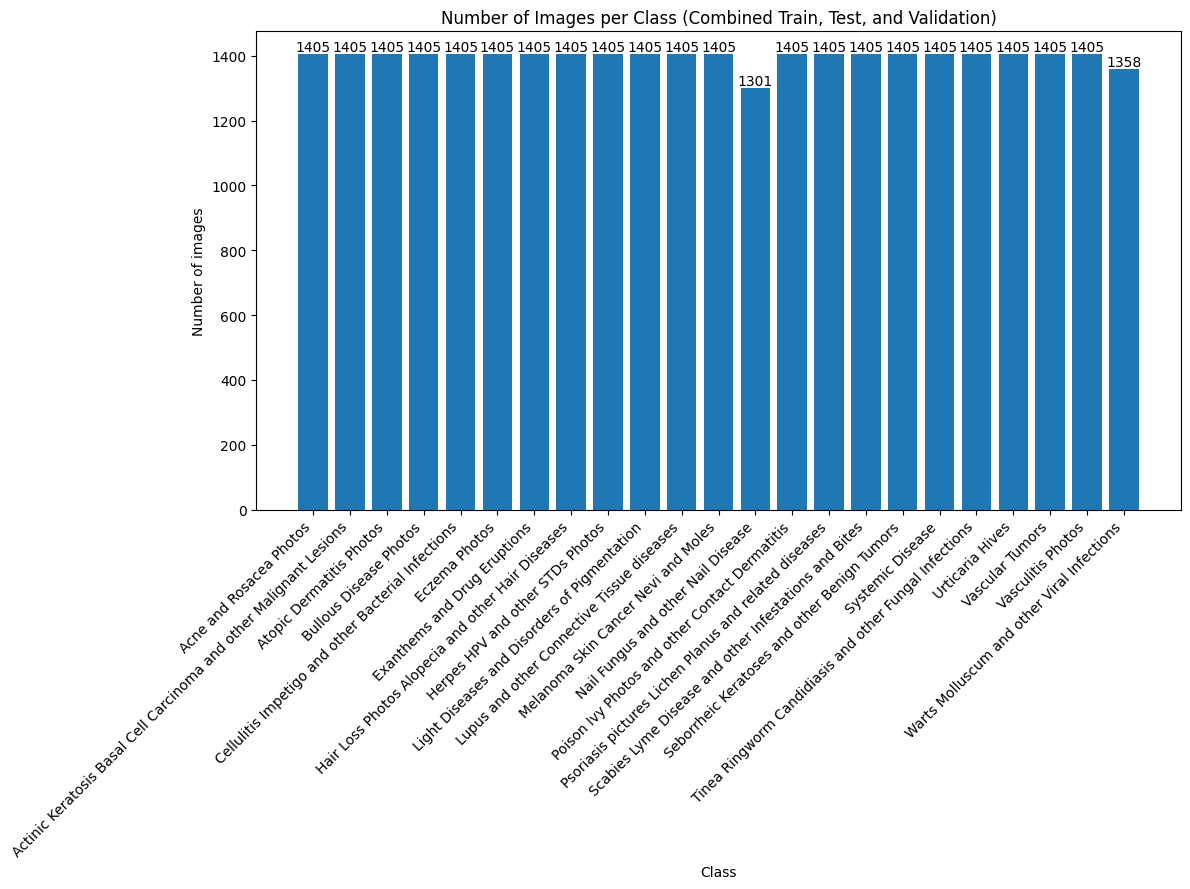

In [3]:
# Set the path to the dataset directory
dataset_dir = 'dataset'

# Set the path to the train, test, and validation directories
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
validation_dir = os.path.join(dataset_dir, 'validation')

# Get the list of class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(train_dir))

# Initialize lists to store the number of images for each class
train_data_counts = []
test_data_counts = []
validation_data_counts = []

# Iterate over each class
for class_name in class_names:
    # Count the number of images in the train directory for the current class
    train_class_dir = os.path.join(train_dir, class_name)
    train_data_count = len(os.listdir(train_class_dir))
    train_data_counts.append(train_data_count)

    # Count the number of images in the test directory for the current class
    test_class_dir = os.path.join(test_dir, class_name)
    test_data_count = len(os.listdir(test_class_dir))
    test_data_counts.append(test_data_count)

    # Count the number of images in the validation directory for the current class
    validation_class_dir = os.path.join(validation_dir, class_name)
    validation_data_count = len(os.listdir(validation_class_dir))
    validation_data_counts.append(validation_data_count)

# Combine the train, test, and validation data counts for each class
combined_data_counts = [train_count + test_count + validation_count for train_count, test_count, validation_count in zip(train_data_counts, test_data_counts, validation_data_counts)]

# Create a larger bar plot for each class with the combined data counts
plt.figure(figsize=(12, 9))
plt.bar(class_names, combined_data_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Combined Train, Test, and Validation)')
plt.xticks(rotation=45, ha='right')

# Add the number of images as text above each bar
for i, count in enumerate(combined_data_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset folder
dataset_path = 'dataset'

# Get the paths to the train, validation, and test folders
train_folder = os.path.join(dataset_path, 'train')
validation_folder = os.path.join(dataset_path, 'validation')
test_folder = os.path.join(dataset_path, 'test')

def train_val_generators():
    # Define the image data generators for training and validation
    train_datagen = ImageDataGenerator(
            rotation_range=30,
            brightness_range=[0.9, 1.3],
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest',
            rescale=1./255
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Create the generator objects for training and validation data
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators()

Found 25730 images belonging to 23 classes.
Found 3205 images belonging to 23 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
# Load the DenseNet121 model pretrained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build the custom classification layers on top of the pre-trained base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(23, activation='softmax')(x)

# Create the final model by specifying the input and output layers
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,071,191 (26.97 MB)

 Trainable params: 33,623 (131.34 KB)

 Non-trainable params: 7,037,568 (26.85 MB)

In [7]:
# Compile the model with Adam optimizer, a learning rate of 1e-3, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping to monitor validation loss, with a minimum change of 0.001 and a patience of 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)

# Train the model using the training generator and validate using the validation generator
# Set a maximum of 15 epochs and include the early stopping callback
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732980086.220774      92 service.cc:145] XLA service 0x7b3a24003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732980086.220828      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732980086.220834      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/403 ━━━━━━━━━━━━━━━━━━━━ 4:17:57 39s/step - accuracy: 0.0156 - loss: 4.4554

I0000 00:00:1732980105.419976      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


403/403 ━━━━━━━━━━━━━━━━━━━━ 437s 991ms/step - accuracy: 0.1085 - loss: 3.6196 - val_accuracy: 0.2256 - val_loss: 2.8282
Epoch 2/15
403/403 ━━━━━━━━━━━━━━━━━━━━ 375s 916ms/step - accuracy: 0.2004 - loss: 2.8880 - val_accuracy: 0.2527 - val_loss: 2.6786
Epoch 3/15
403/403 ━━━━━━━━━━━━━━━━━━━━ 376s 917ms/step - accuracy: 0.2260 - loss: 2.7407 - val_accuracy: 0.2218 - val_loss: 2.7488
Epoch 4/15
403/403 ━━━━━━━━━━━━━━━━━━━━ 376s 917ms/step - accuracy: 0.2267 - loss: 2.7269 - val_accuracy: 0.2708 - val_loss: 2.5852
Epoch 5/15
403/403 ━━━━━━━━━━━━━━━━━━━━ 368s 897ms/step - accuracy: 0.2377 - loss: 2.6951 - val_accuracy: 0.2827 - val_loss: 2.5429
Epoch 6/15
403/403 ━━━━━━━━━━━━━━━━━━━━ 370s 903ms/step - accuracy: 0.2482 - loss: 2.6501 - val_accuracy: 0.2590 - val_loss: 2.5794
Epoch 7/15
403/403 ━━━━━━━━━━━━━━━━━━━━ 371s 905ms/step - accuracy: 0.2418 - loss: 2.6574 - val_accuracy: 0.2749 - val_loss: 2.5353
Epoch 8/15
403/403 ━━━━━━━━━━━━━━━━━━━━ 375s 914ms/step - accuracy: 0.2496 - loss: 2.65

In [8]:
# Make the base model trainable
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-9)

# Train the model with the defined callbacks
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
256/403 ━━━━━━━━━━━━━━━━━━━━ 2:14 913ms/step - accuracy: 0.2394 - loss: 2.6754

I0000 00:00:1732983948.820986      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion', 12 bytes spill stores, 12 bytes spill loads



403/403 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.2553 - loss: 2.6227 - val_accuracy: 0.4041 - val_loss: 2.1720 - learning_rate: 1.0000e-04
Epoch 2/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 382s 932ms/step - accuracy: 0.3720 - loss: 2.2548 - val_accuracy: 0.4680 - val_loss: 1.9922 - learning_rate: 1.0000e-04
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 382s 932ms/step - accuracy: 0.4448 - loss: 2.0733 - val_accuracy: 0.4911 - val_loss: 1.8996 - learning_rate: 1.0000e-04
Epoch 4/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 382s 932ms/step - accuracy: 0.4988 - loss: 1.9072 - val_accuracy: 0.5426 - val_loss: 1.7352 - learning_rate: 1.0000e-04
Epoch 5/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 376s 915ms/step - accuracy: 0.5279 - loss: 1.7724 - val_accuracy: 0.5825 - val_loss: 1.6379 - learning_rate: 1.0000e-04
Epoch 6/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 374s 911ms/step - accuracy: 0.5761 - loss: 1.6365 - val_accuracy: 0.6022 - val_loss: 1.5020 - learning_rate: 1.0000e-04
Epoch 7/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 376s 917ms/ste

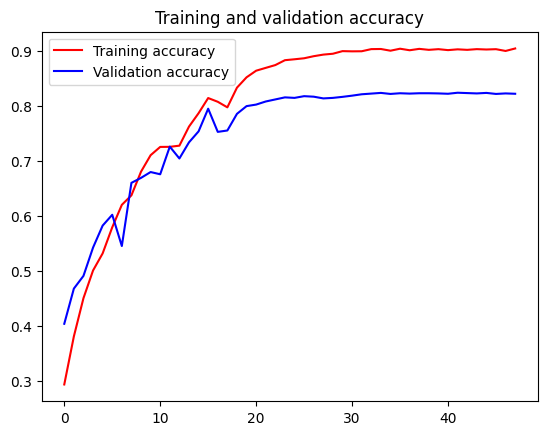

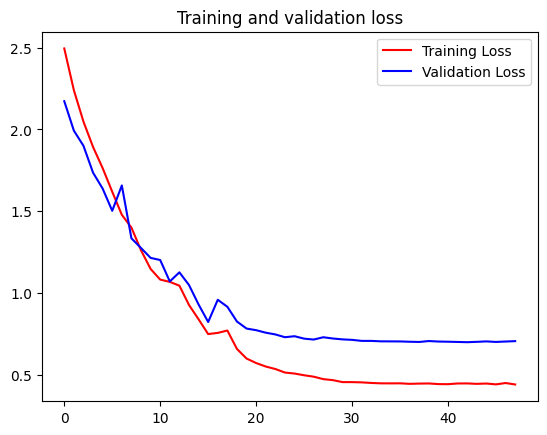

In [15]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# Path to the test dataset folder
test_folder = 'dataset/test'

# Generate the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

Found 3229 images belonging to 23 classes.


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Print the classification report
print(classification_report(true_labels, predicted_labels))

# Print the confusion matrix
print(confusion_matrix(true_labels, predicted_labels))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       141
           1       0.77      0.60      0.67       141
           2       0.83      0.91      0.87       141
           3       0.92      0.88      0.90       141
           4       0.87      0.97      0.92       141
           5       0.64      0.61      0.62       141
           6       0.88      0.91      0.90       141
           7       0.91      0.96      0.93       141
           8       0.83      0.87      0.85       141
           9       0.86      0.89      0.88       141
          10       0.91      0.91      0.91       141
          11       0.90      0.91      0.90       141
          12       0.83      0.74      0.78       131
          13       0.90      0.97      0.93       141
          14       0.64      0.59      0.61       141
          15       0.88      0.96      0.92       141
          16       0.74      0.55     

In [19]:
model.save('skinDiseaseClassification.h5')

In [20]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('skinDiseaseClassification.h5')

In [48]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a single image for prediction
img_path = "/kaggle/input/dermnet/test/Warts Molluscum and other Viral Infections/12wartCommon0403061.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

# Predict
predictions = model.predict(img_array)

# Assuming you have the 'class_names' variable from when you created the ImageDataGenerator
# If not, you need to retrieve or recreate this list
predicted_class = class_names[np.argmax(predictions)]  # Use the class_names variable directly
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class: Warts Molluscum and other Viral Infections
